In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
import pickle

from sklearn import svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from Bio.SeqUtils.ProtParam import ProteinAnalysis
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, cross_val_predict

%matplotlib inline

## This project uses Machine Learning to approach an important problem in functional genomics: the discovery of transcription-factor binding sites in DNA.

## The goal of this project is to create a Machine Learning Model that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not.

## This notebook is based on data provided in a Deep Learning in Genomics Primer tutorial made by Mr. Abubakar Abid, who is part of Professor Zou's group in Stanford University.

In [2]:
SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
df = pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences'])

In [3]:
df.head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGCGTCG
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTAGCCT
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGCCCTG
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATATGGT


In [4]:
df.shape

(2000, 1)

In [5]:
df.columns

Index(['Sequences'], dtype='object')

## the labels are structured as follows: a "1" indicates that a protein bound to the sequence, while a "0" indicates that the protein did not. |

In [6]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

In [7]:
print(labels[0])

0


In [8]:
print(labels[0:10])

['0', '0', '0', '1', '1', '1', '1', '0', '0', '0']


In [9]:
df['class'] = labels

In [10]:
df.head()

,Sequences,class
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC,0
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGCGTCG,0
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTAGCCT,0
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGCCCTG,1
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATATGGT,1


In [11]:
df.columns

Index(['Sequences', 'class'], dtype='object')

In [12]:
df.shape

(2000, 2)

In [13]:
df.dtypes

Sequences    object
class        object
dtype: object

In [14]:
df['class'].unique()

array(['0', '1'], dtype=object)

In [15]:
# use list comprehension to create a list of DNA sequences containing regulatory motif, CGACCGAACTCC
tf_site_list  = ['1' if 'CGACCGAACTCC' in seq else '0' for seq in df['Sequences']]

In [16]:
tf_site_list[0:10]

['0', '0', '0', '1', '1', '1', '1', '0', '0', '0']

In [17]:
list(df['class'])[0:10]

['0', '0', '0', '1', '1', '1', '1', '0', '0', '0']

In [18]:
df.head()

,Sequences,class
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC,0
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGCGTCG,0
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTAGCCT,0
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGCCCTG,1
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATATGGT,1


In [19]:
df.shape

(2000, 2)

In [20]:
df = df.sample(frac= 1.0)

In [21]:
df.head()

,Sequences,class
337,GTCCCGCTGGCAATCCGGCGCTGCGTCGACCGAACTCCCTGATTCGATAA,1
1621,TAAAGTATCACATCGAATGACGGTCCAAGGTGTTCCGGCGCAGTAAGCTC,0
1859,ACGTCATGACCTGAGAATCCCGATGATATGCGACCGAACTCCTATCGGAG,1
691,ATCTTACTCCTACGTCCCCGACCGAACTCCACTCCAAACGAGGGTCACCT,1
703,GTCCTATTGGCGAAACAAGCTAGTATTCCAACAACTAGCAACGGCGAGAT,0


In [22]:
df.shape

(2000, 2)

In [23]:
#########################################################################################

## In this notebook, the DNA sequences will be converted into CountVectors that counts the number of occurences of substrings of a specified length, in this case 12 contigous letters/bases, that appear in each DNA sequence.

In [24]:
peptide_size = 12
vect_ = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(peptide_size,peptide_size))

In [25]:
y = df['class']

In [26]:
X = vect_.fit_transform(df.Sequences)

In [27]:
X.shape

(2000, 69302)

## Split the data

In [28]:
train_features, test_features, train_labels, test_labels = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [29]:
print(train_labels.shape)
print(test_labels.shape)

(1500,)
(500,)


In [30]:
train_labels.unique()

array(['1', '0'], dtype=object)

In [31]:
train_features[0]

<1x69302 sparse matrix of type '<class 'numpy.int64'>'
	with 39 stored elements in Compressed Sparse Row format>

## Logistic Regression Model for Classification

In [32]:
# Logistic Regression 
lr = LogisticRegression()
lr.fit(train_features, train_labels)

print("Logistic Regression Score: {:.2f}".format(lr.score(test_features, test_labels)))

Logistic Regression Score: 1.00


In [33]:
# Generate Confusion Matrix for Logistic Regression
actual = test_labels
predictions = lr.predict(test_features)
print('Confusion Matrix for Logistic Regression Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Logistic Regression Model

[[246   0]
 [  0 254]]


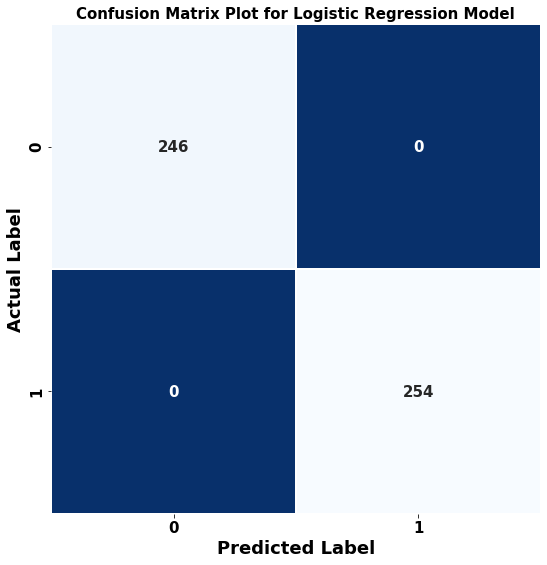

In [34]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
kwargs = {'size':15,'weight': 'bold'}
plt.figure(figsize=(12,9))
#plt.matshow(cm, fignum=1)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',cbar=None,annot_kws=kwargs);
plt.title('Confusion Matrix Plot for Logistic Regression Model',fontsize=15, fontweight='bold')
#plt.colorbar()
plt.ylabel('Actual Label',fontsize=18,fontweight='bold');
plt.xlabel('Predicted Label',fontsize=18, fontweight='bold');
plt.xticks(fontsize =15,fontweight='bold')
plt.yticks(fontsize =15,fontweight='bold')

plt.show();


## Cross Validation of Logistic Regression

In [35]:
#instantiate a logistic regression classifier
lr_cv = LogisticRegression(random_state = 1)
scores = cross_val_score(lr_cv,X,y, cv = 5)
print("Cross-validation scores for Logistic Regression: {}".format(scores))
print()
print("The average accuracy score for Logistic Regression is: ")
print(np.mean(scores))

Cross-validation scores for Logistic Regression: [1. 1. 1. 1. 1.]

The average accuracy score for Logistic Regression is: 
1.0


In [36]:
def plot_and_return_top_features(classifier, vectorizer, top_features=20):
    """
    Plot the top features in a binary classification model and remove possible overlap.
    Adapted from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
    and https://stackoverflow.com/a/26980472 by @kjam
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:top_features]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-top_features:]
    top_coefficients = np.hstack([topn_class1, topn_class2])
    if set(topn_class1).union(topn_class2):
        top_coefficients = topn_class1
        for ce in topn_class2:
            if ce not in topn_class1:
                #top_coefficients.append(x)-- Note: error in original code use ce instead of x
                top_coefficients.append(ce)
                
    fig, ax = plt.subplots(figsize=(15, 5))
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    fontweight = 'bold'
    colors = ['red' if c < 0 else 'blue' for c in [tc[0] for tc in top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), [tc[0] for tc in top_coefficients], color=colors)
    plt.xticks(np.arange(len(top_coefficients)),
               [tc[1] for tc in top_coefficients], rotation=60, ha='right',fontsize = 14,fontweight='bold')
    plt.show()
    return top_coefficients

## Spoiler alert: the true regulatory motif, the DNA sequence that binds to this transcription factor,  is CGACCGAACTCC. 

## Inspect the model:
### examine those features, the DNA sequences of 12 bases, that are frequently found in DNA sequences that bind to the transcription factor.

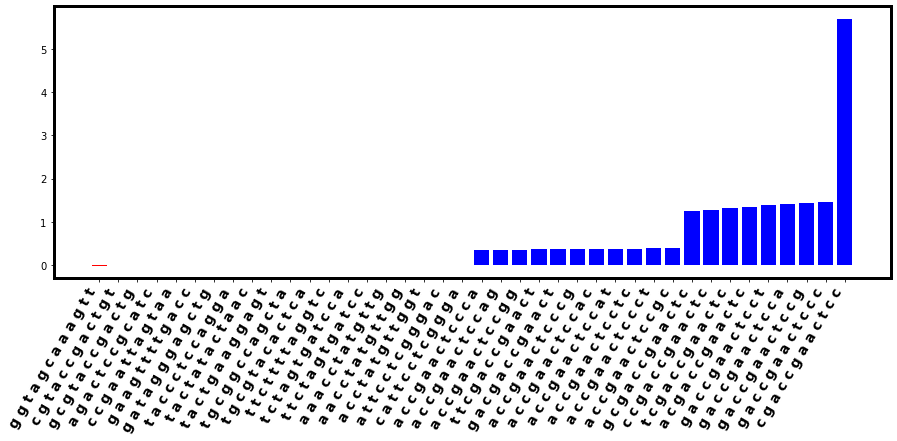

[(-0.021987403827076615, 'g g t a g c a a a g t t'),
 (-0.014798330556055898, 'c g t a c c g a c t g t'),
 (-0.014798330556055898, 'g c g t a c c g a c t g'),
 (-0.014796481425543897, 'a g a c t c c g c a t c'),
 (-0.014796481425543897, 'c c g a a t t a g t a a'),
 (-0.014796481425543897, 'g a a g t t t t g a c c'),
 (-0.014796481425543897, 'g a t a g g g a g c t g'),
 (-0.014796481425543897, 't a c c c t c c a g g a'),
 (-0.014796481425543897, 't a c t a t a c t a a c'),
 (-0.014796481425543897, 't a c t g a a g g a g t'),
 (-0.014796481425543897, 't g c g g c c a g c t a'),
 (-0.014796481425543897, 't g c g t a c a c t c a'),
 (-0.014796481425543897, 't t c t t t t a g g t c'),
 (-0.014713032462528815, 't c t a g t g a t c c a'),
 (-0.014713032462528815, 't t c t a g t g a t c c'),
 (-0.01463088272497331, 'a a a c c t a t g t t g'),
 (-0.01463088272497331, 'a a c c t a t g t t g g'),
 (-0.01463088272497331, 'a c c t a t g t t g g t'),
 (-0.01463088272497331, 'a t t c c t c g g g a c'

In [37]:
plot_and_return_top_features(lr, vect_ , top_features=20)

## In the above Logistic Regression model, the substring CGACCGAACTCC is frequently found in DNA sequences that bind to this transcription factor as expected. Not suprisingly, this sequence IS the regulatory motif CGACCGAACTCC. This confirms that this model is good at predicting which DNA sequences will bind to this protein. 